## Data loading and Model Training/Tuning

In [32]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [33]:
df = pd.read_csv('data/heloc_dataset_v1.csv')
mask = (df.iloc[:, 1:] == -9).all(axis=1)
df = df[~mask]

In [34]:
X = df.drop('RiskPerformance', axis=1)  # Features
y = df['RiskPerformance']               # Target variable

# Initialize the LabelEncoder
label_encoder = LabelEncoder()
# Fit label encoder and return encoded labels
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into train and test sets using the encoded labels
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

### XGBoost

In [35]:
# Create an instance of the XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Fit the model with training data
model.fit(X_train, y_train)

# Make predictions (for example, on the test set)
y_pred = model.predict(X_test)

# Check the accuracy of your model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.71


#### Gridsearch

In [36]:
from sklearn.model_selection import GridSearchCV

# Parameters grid to search
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

# Initialize the XGBClassifier
xgb_model = xgb.XGBClassifier(eval_metric='logloss')

# Setup the grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)

# Fit grid search
best_model = grid_search.fit(X_train, y_train)

# Print the best parameters and highest accuracy
print("Best parameters found: ", best_model.best_params_)
print("Best accuracy found: ", best_model.best_score_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsampl

#### Best parameters

In [37]:
# Create an instance of the XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7)

# Fit the model with training data
model.fit(X_train, y_train)

# Make predictions (for example, on the test set)
y_pred = model.predict(X_test)

# Check the accuracy of your model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.74


#### Cross validation

In [48]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from numpy import mean, std

#evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print("done!")
print("evaluating:")

# report performance
print(n_scores)
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

done!
evaluating:
[0.75063291 0.73037975 0.73417722 0.71012658 0.73544304 0.7443038
 0.7756654  0.72243346 0.71609632 0.75031686]
Accuracy: 0.737 (0.018)


## EDA 

In [39]:
import pygwalker as pyg

In [42]:
pyg.walk(df, dark='dark')

Box(children=(HTML(value='<div id="ifr-pyg-000618a3165343a2hevj7xSrbmVz5Zo0" style="height: auto">\n    <head>…

## Clustering

### K-Means

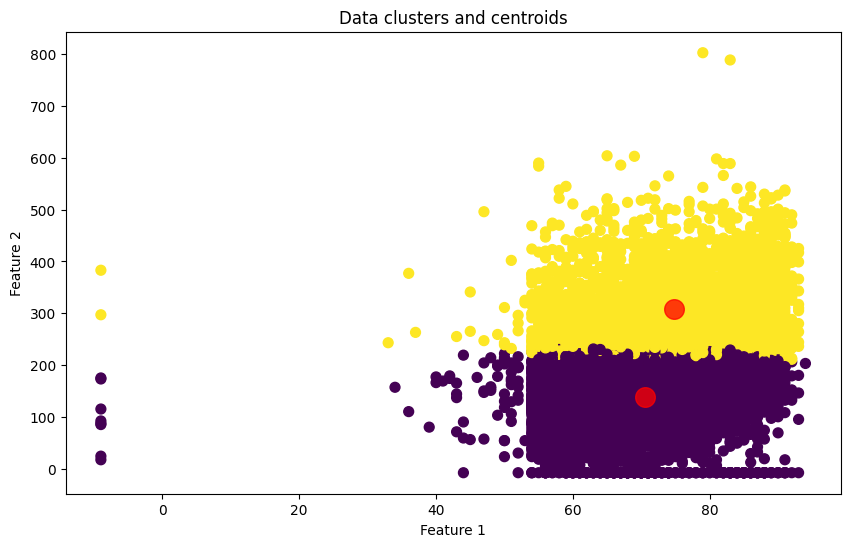

In [45]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming 'X' is your dataset (features)

# Number of clusters
k = 2  # You might need to experiment with different values of k

# Create a KMeans instance with k clusters
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit model to data
y_kmeans = kmeans.fit_predict(X)

# Visualize the clusters (assuming the first two columns are meaningful for plotting)
plt.figure(figsize=(10, 6))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75)  # Mark cluster centers
plt.title('Data clusters and centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


#### Elbow Method

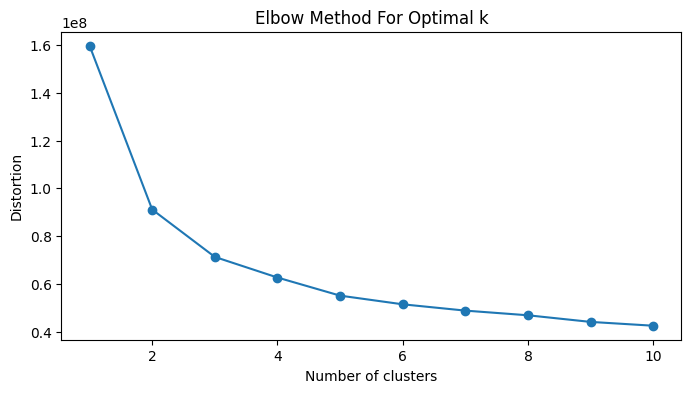

In [44]:
# Calculate distortions for a range of number of clusters
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(X)
    distortions.append(km.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), distortions, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()


#### PCA

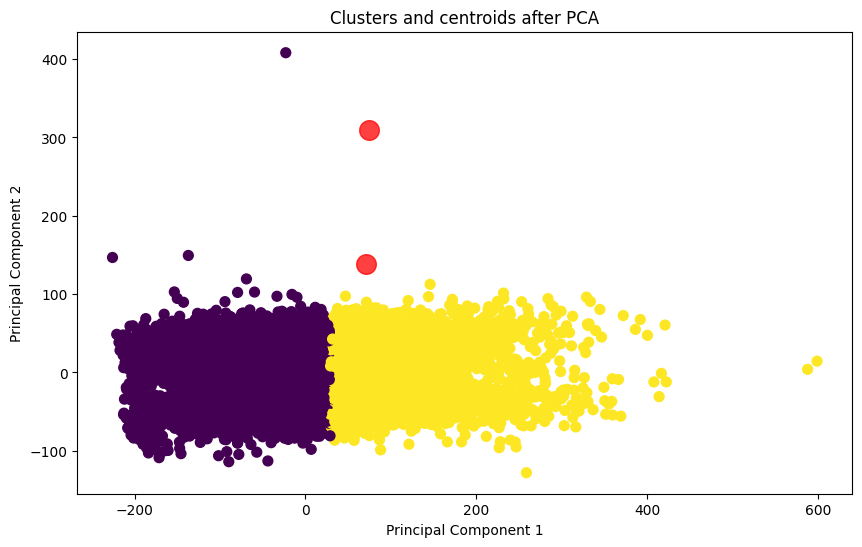

In [47]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'X' contains all features you want to include
kmeans = KMeans(n_clusters=2, random_state=42)
y_kmeans = kmeans.fit_predict(X)

# Apply PCA for dimensionality reduction to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, alpha=0.75)
plt.title('Clusters and centroids after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


### DBSCAN (niet goed nog)

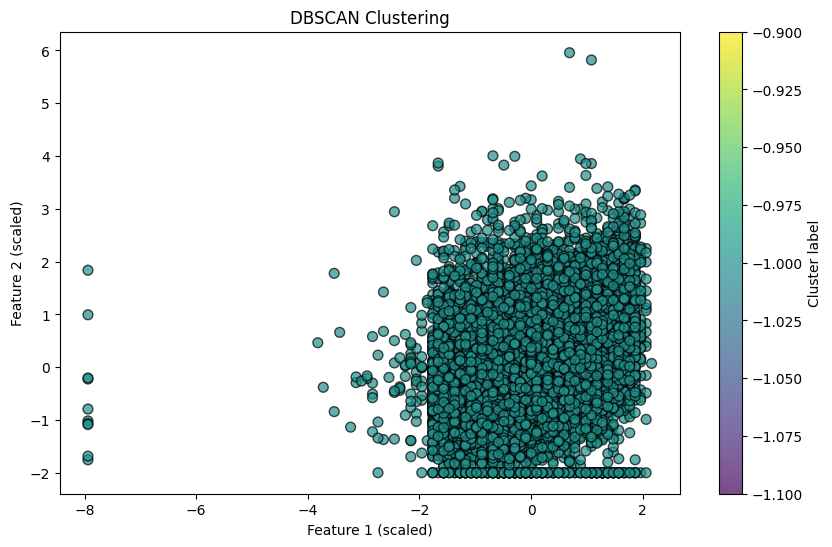

In [54]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming 'X' is your dataset (features)
# Standardize the features (important for distance-based algorithms like DBSCAN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DBSCAN instance
# These parameters are starting points. You might need to adjust them based on your data.
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit DBSCAN to the scaled data
clusters = dbscan.fit_predict(X_scaled)

# Plot the clusters (assuming the first two features can be used for a meaningful 2D plot)
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', marker='o', s=50, alpha=0.7, edgecolor='k')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.colorbar(label='Cluster label')
plt.show()

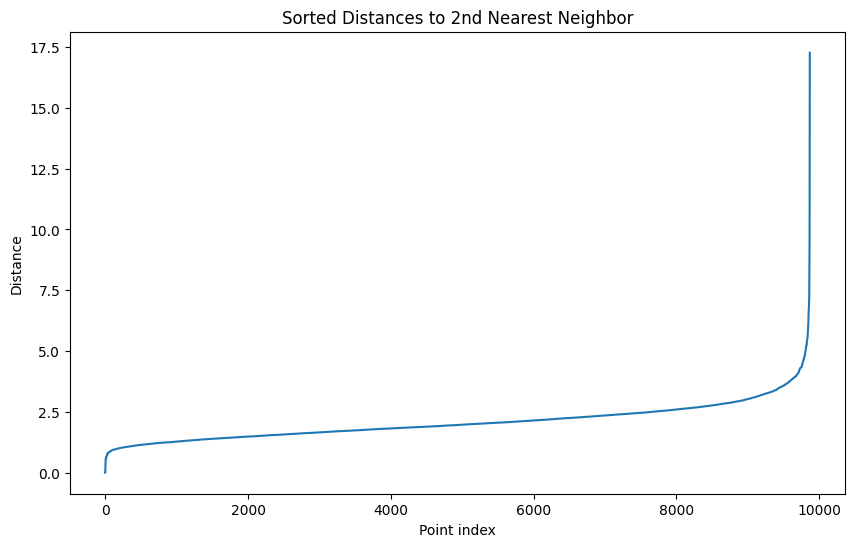

In [50]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Use NearestNeighbors to find the distance to the nearest `min_samples` points
neigh = NearestNeighbors(n_neighbors=5)  # same as min_samples
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort the distances
distances = np.sort(distances, axis=0)
distances = distances[:, 1]  # The second closest neighbor

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('Sorted Distances to 2nd Nearest Neighbor')
plt.xlabel('Point index')
plt.ylabel('Distance')
plt.show()